In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchsummary import summary
from sklearn import preprocessing
import torch.optim as optim
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/song_features.csv"
df = pd.read_csv(path)


Splitting our Data

In [ ]:
#Select relevant features
features_of_interest = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",\
                        "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

#Shuffle Dataset
df = df.sample(frac=1, random_state = 19).reset_index(drop=True)

#80/20 Split between Train and Test
train, test = train_test_split(df, test_size=0.2)

# train.to_csv("/content/drive/My Drive/song_features_train.csv")
# test.to_csv("/content/drive/My Drive/song_features_test.csv")


#Subdivide training test into its features and labels
trainx = train[features_of_interest]
trainy = train[["genre"]]

testx = test[features_of_interest]
testy = test[["genre"]]

print(train.dtypes)

msd_track_id         object
msd_song_id          object
spotify_id           object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms         float64
time_signature      float64
genre                object
dtype: object


Data Exploration

In [ ]:
print(df.head())

         msd_track_id         msd_song_id              spotify_id  \
0  TRSRCBF128F14AAB5B  SOXRGFU12A6D4FB335  5c0SsjmexSa9QJ5MWoepQK   
1  TRDNJQV128F931B1A9  SOCZTRA12AB0188521  6wQUObaXYOhR3P6Jsfq50t   
2  TRNXCSI128F149FA16  SOGZSHD12A6D4FAD5C  7791BKdHoXssT9SbybJI0P   
3  TRFCTYD12903CC65A1  SOTCQXT12AB0185210  3zBltgnm4nLnuUoUP5xgof   
4  TRKIPLD128F42BAA46  SOBRWYE12A8C1412A5  18Ta9ptX7HLxb2wEoGHV83   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.747   0.866  10.0    -7.353   0.0       0.0480        0.2190   
1         0.451   0.130   2.0   -19.210   1.0       0.0289        0.4740   
2         0.491   0.143   8.0   -12.343   1.0       0.0326        0.7850   
3         0.228   0.707  11.0    -8.240   0.0       0.0391        0.0875   
4         0.588   0.505   5.0    -8.776   1.0       0.0283        0.1710   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.470000    0.0732    0.889   88.026 

The shape of our dataset: (168379, 17)




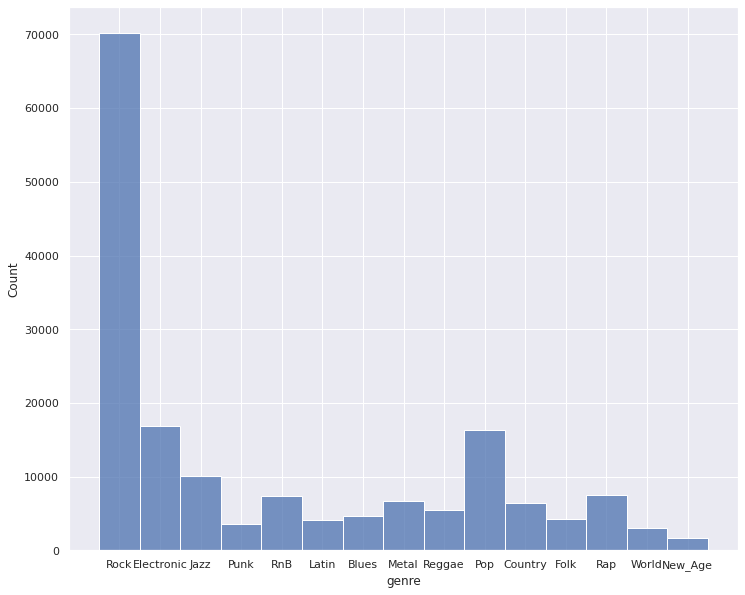

In [ ]:
print("The shape of our dataset: " + str(train.shape) + "\n\n")
value_bins = train['genre'].value_counts()
sns.set(rc={'figure.figsize':(12,10)})
sns.histplot(train["genre"])

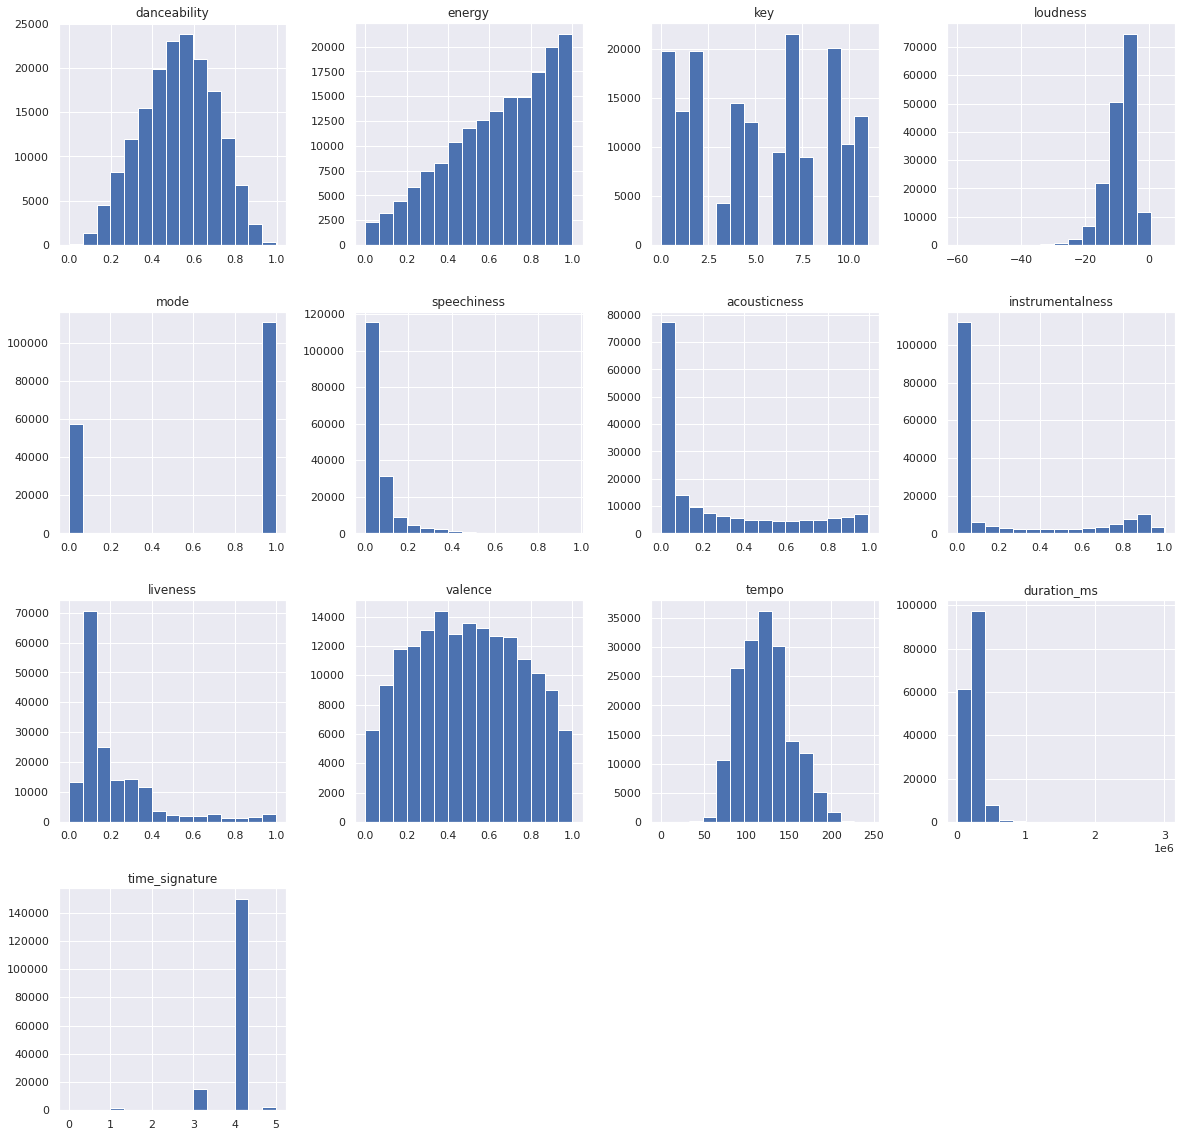

In [ ]:
train.hist(bins=15, figsize=(20, 20), layout=(4, 4));

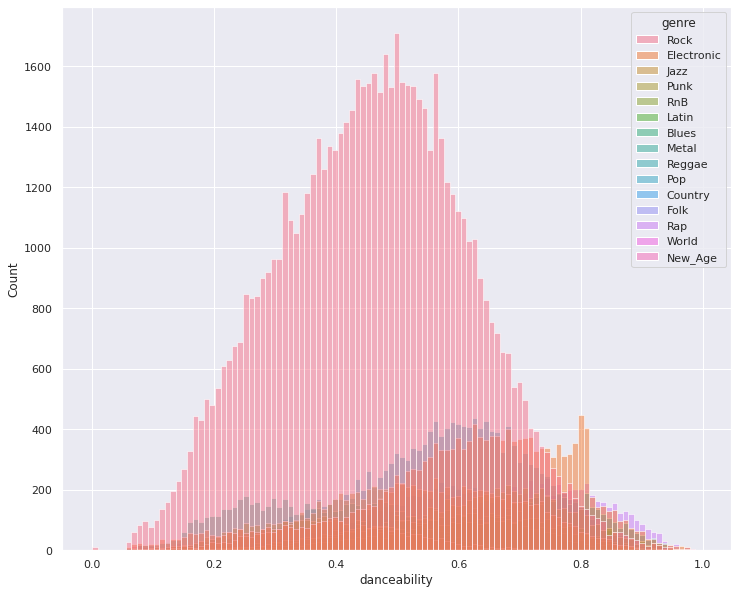

In [ ]:
sns.histplot(data=train, x="danceability", hue="genre")

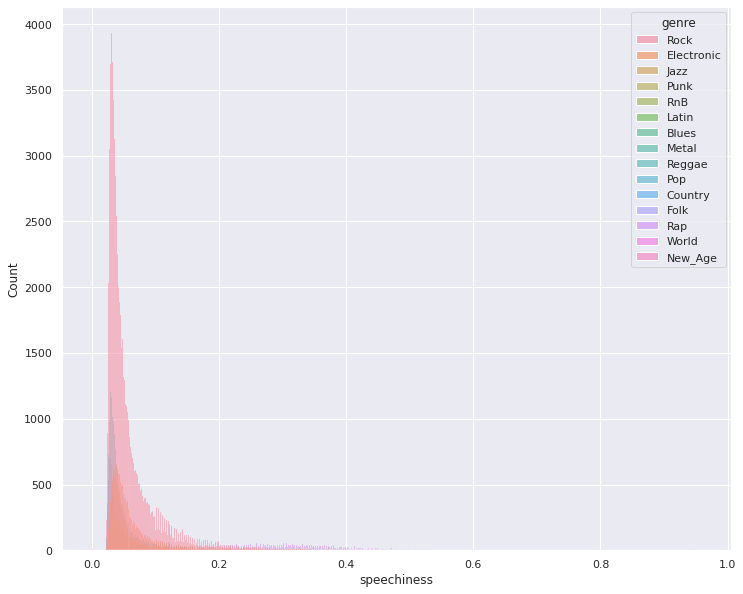

In [ ]:
sns.histplot(data=train, x="speechiness", hue="genre")

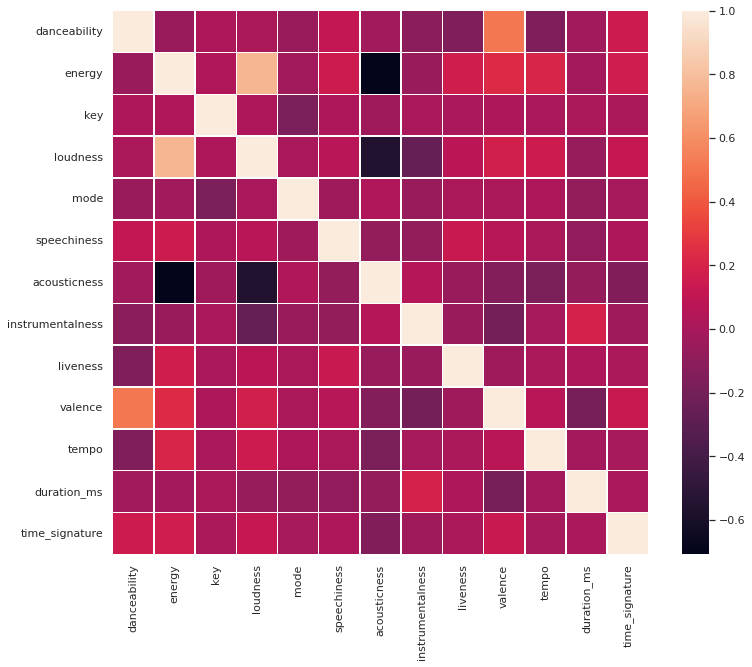

In [ ]:
ax = sns.heatmap(trainx.corr(), linewidths = .5);


In [ ]:
#Dataframe to Numpy Arrays

if isinstance(trainx, pd.DataFrame):
  print("Converted trainx from Dataframe to Numpy")
  trainx = trainx.to_numpy(dtype = float)
if isinstance(trainy, pd.DataFrame):
  trainy = trainy.to_numpy().reshape(-1, 1)
  print("Converted trainy from Dataframe to Numpy")
if isinstance(testx, pd.DataFrame):
  testx = testx.to_numpy(dtype = float)
  print("Converted testx from Dataframe to Numpy")
if isinstance(testy, pd.DataFrame):
  testy = testy.to_numpy().reshape(-1, 1)
  print("Converted testy from Dataframe to Numpy")

#Transformations on X
pt = preprocessing.PowerTransformer()
pt.fit(trainx)
trainx = torch.from_numpy(pt.transform(trainx))

pt_test = preprocessing.PowerTransformer()
pt_test.fit(testx)
testx = torch.from_numpy(pt_test.transform(testx))


#Transformations on Y

# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(trainy)
# trainy_onehot = torch.from_numpy(enc.transform(trainy).toarray()).type(torch.LongTensor)

yle = preprocessing.LabelEncoder()
yle.fit(trainy.reshape((-1,)))
trainy_le = torch.from_numpy(yle.transform(trainy.reshape((-1,))))

yle_test = preprocessing.LabelEncoder()
yle_test.fit(testy.reshape((-1,)))
testy_le = torch.from_numpy(yle_test.transform(testy.reshape((-1,))))


Converted trainx from Dataframe to Numpy
Converted trainy from Dataframe to Numpy
Converted testx from Dataframe to Numpy
Converted testy from Dataframe to Numpy


In [ ]:
class Net(nn.Module):
  def __init__(self, numFeatures, numGenres):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(numFeatures,14) #Intial number of feautres
    self.fc2 = nn.Linear(14,numGenres)
  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x

In [ ]:
class MillionSongTrainDataset(torch.utils.data.Dataset):
  def __init__(self,dataset,labels):
    self.labels = trainy
    self.dataset = dataset
    self.labels = labels
  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
    return self.dataset[idx],self.labels[idx]


In [ ]:
batch_size = 32
num_folds  = 4 
epochs = 30
numGenres = 15
N, D = trainx.shape
training_str_templ = "Training for Fold Number {numFold}; Epoch Number {numEpoch}"
validation_str_templ = "Validation for Fold Number {numFold}"


In [ ]:
train_dict = {}
val_dict = {}
for k in range(num_folds):
  net = Net(D,numGenres)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.00005, momentum=0.9)
  print()
  print()
  xtrain = np.concatenate((trainx[:k*(N//num_folds)],trainx[min(N,(k+1)*(N//num_folds)):]), axis = 0)
  ytrain = np.concatenate((trainy_le[:k*(N//num_folds)],trainy_le[min(N,(k+1)*(N//num_folds)):]), axis = 0)

  trainloader = torch.utils.data.DataLoader(MillionSongTrainDataset(xtrain,ytrain), batch_size=batch_size, shuffle=True)

  xval = trainx[k*(N//num_folds):min(N,(k+1)*(N//num_folds))]
  yval = trainy_le[k*(N//num_folds):min(N,(k+1)*(N//num_folds))]

  valloader = torch.utils.data.DataLoader(MillionSongTrainDataset(xval,yval), batch_size=64, shuffle=True)

  train_losses = []
  valid_losses = []
  for epoch in range(epochs):

    net.train()
    running_loss = 0.0
    valid_running_loss = 0.0
    for i,data in tqdm(enumerate(trainloader,0), desc = training_str_templ.format(numFold=k,numEpoch=epoch)):
      local_batch, local_labels = data
      optimizer.zero_grad()
      outputs = net(local_batch.float())
      loss = criterion(outputs, local_labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    net.eval()

    for val_data, val_labels in valloader:
      output = net(val_data.float())
      loss = criterion(output,val_labels)
      valid_running_loss += loss.item()

    print(f'[Epoch: {epoch}, Num Mini-batches: {len(trainloader):5d}] Training loss: {running_loss / len(trainloader):.3f}')
    train_losses.append(running_loss / len(trainloader))
    train_dict[k] = train_losses

    print(f'[Epoch: {epoch}, Num Mini-batches: {len(valloader):5d}] Validation loss: {valid_running_loss / len(valloader):.3f}')
    valid_losses.append(valid_running_loss / len(valloader))
    val_dict[k] = valid_losses

Training for Fold Number 0; Epoch Number 0: 3947it [00:03, 1176.66it/s]


[Epoch: 0, Num Mini-batches:  3947] Training loss: 2.609
[Epoch: 0, Num Mini-batches:   658] Validation loss: 2.428


Training for Fold Number 0; Epoch Number 1: 3947it [00:03, 1175.10it/s]


[Epoch: 1, Num Mini-batches:  3947] Training loss: 2.288
[Epoch: 1, Num Mini-batches:   658] Validation loss: 2.190


Training for Fold Number 0; Epoch Number 2: 3947it [00:03, 1177.54it/s]


[Epoch: 2, Num Mini-batches:  3947] Training loss: 2.142
[Epoch: 2, Num Mini-batches:   658] Validation loss: 2.117


Training for Fold Number 0; Epoch Number 3: 3947it [00:03, 1176.83it/s]


[Epoch: 3, Num Mini-batches:  3947] Training loss: 2.095
[Epoch: 3, Num Mini-batches:   658] Validation loss: 2.082


Training for Fold Number 0; Epoch Number 4: 3947it [00:03, 1176.19it/s]


[Epoch: 4, Num Mini-batches:  3947] Training loss: 2.061
[Epoch: 4, Num Mini-batches:   658] Validation loss: 2.046


Training for Fold Number 0; Epoch Number 5: 3947it [00:03, 1158.52it/s]


[Epoch: 5, Num Mini-batches:  3947] Training loss: 2.022
[Epoch: 5, Num Mini-batches:   658] Validation loss: 2.006


Training for Fold Number 0; Epoch Number 6: 3947it [00:03, 1179.16it/s]


[Epoch: 6, Num Mini-batches:  3947] Training loss: 1.983
[Epoch: 6, Num Mini-batches:   658] Validation loss: 1.969


Training for Fold Number 0; Epoch Number 7: 3947it [00:03, 1147.46it/s]


[Epoch: 7, Num Mini-batches:  3947] Training loss: 1.947
[Epoch: 7, Num Mini-batches:   658] Validation loss: 1.935


Training for Fold Number 0; Epoch Number 8: 3947it [00:03, 1183.88it/s]


[Epoch: 8, Num Mini-batches:  3947] Training loss: 1.914
[Epoch: 8, Num Mini-batches:   658] Validation loss: 1.905


Training for Fold Number 0; Epoch Number 9: 3947it [00:03, 1167.24it/s]


[Epoch: 9, Num Mini-batches:  3947] Training loss: 1.887
[Epoch: 9, Num Mini-batches:   658] Validation loss: 1.881


Training for Fold Number 0; Epoch Number 10: 3947it [00:03, 1181.19it/s]


[Epoch: 10, Num Mini-batches:  3947] Training loss: 1.866
[Epoch: 10, Num Mini-batches:   658] Validation loss: 1.863


Training for Fold Number 0; Epoch Number 11: 3947it [00:03, 1171.37it/s]


[Epoch: 11, Num Mini-batches:  3947] Training loss: 1.849
[Epoch: 11, Num Mini-batches:   658] Validation loss: 1.849


Training for Fold Number 0; Epoch Number 12: 3947it [00:03, 1189.53it/s]


[Epoch: 12, Num Mini-batches:  3947] Training loss: 1.837
[Epoch: 12, Num Mini-batches:   658] Validation loss: 1.837


Training for Fold Number 0; Epoch Number 13: 3947it [00:03, 1184.33it/s]


[Epoch: 13, Num Mini-batches:  3947] Training loss: 1.826
[Epoch: 13, Num Mini-batches:   658] Validation loss: 1.828


Training for Fold Number 0; Epoch Number 14: 3947it [00:03, 1165.34it/s]


[Epoch: 14, Num Mini-batches:  3947] Training loss: 1.818
[Epoch: 14, Num Mini-batches:   658] Validation loss: 1.821


Training for Fold Number 0; Epoch Number 15: 3947it [00:03, 1179.52it/s]


[Epoch: 15, Num Mini-batches:  3947] Training loss: 1.811
[Epoch: 15, Num Mini-batches:   658] Validation loss: 1.815


Training for Fold Number 0; Epoch Number 16: 3947it [00:03, 1162.88it/s]


[Epoch: 16, Num Mini-batches:  3947] Training loss: 1.805
[Epoch: 16, Num Mini-batches:   658] Validation loss: 1.809


Training for Fold Number 0; Epoch Number 17: 3947it [00:03, 1167.18it/s]


[Epoch: 17, Num Mini-batches:  3947] Training loss: 1.800
[Epoch: 17, Num Mini-batches:   658] Validation loss: 1.804


Training for Fold Number 0; Epoch Number 18: 3947it [00:03, 1177.50it/s]


[Epoch: 18, Num Mini-batches:  3947] Training loss: 1.794
[Epoch: 18, Num Mini-batches:   658] Validation loss: 1.798


Training for Fold Number 0; Epoch Number 19: 3947it [00:03, 1185.34it/s]


[Epoch: 19, Num Mini-batches:  3947] Training loss: 1.789
[Epoch: 19, Num Mini-batches:   658] Validation loss: 1.793


Training for Fold Number 0; Epoch Number 20: 3947it [00:03, 1186.96it/s]


[Epoch: 20, Num Mini-batches:  3947] Training loss: 1.783
[Epoch: 20, Num Mini-batches:   658] Validation loss: 1.787


Training for Fold Number 0; Epoch Number 21: 3947it [00:03, 1171.76it/s]


[Epoch: 21, Num Mini-batches:  3947] Training loss: 1.777
[Epoch: 21, Num Mini-batches:   658] Validation loss: 1.781


Training for Fold Number 0; Epoch Number 22: 3947it [00:03, 1167.37it/s]


[Epoch: 22, Num Mini-batches:  3947] Training loss: 1.772
[Epoch: 22, Num Mini-batches:   658] Validation loss: 1.776


Training for Fold Number 0; Epoch Number 23: 3947it [00:03, 1142.55it/s]


[Epoch: 23, Num Mini-batches:  3947] Training loss: 1.767
[Epoch: 23, Num Mini-batches:   658] Validation loss: 1.772


Training for Fold Number 0; Epoch Number 24: 3947it [00:03, 1179.36it/s]


[Epoch: 24, Num Mini-batches:  3947] Training loss: 1.762
[Epoch: 24, Num Mini-batches:   658] Validation loss: 1.767


Training for Fold Number 0; Epoch Number 25: 3947it [00:03, 1164.36it/s]


[Epoch: 25, Num Mini-batches:  3947] Training loss: 1.758
[Epoch: 25, Num Mini-batches:   658] Validation loss: 1.764


Training for Fold Number 0; Epoch Number 26: 3947it [00:03, 1170.62it/s]


[Epoch: 26, Num Mini-batches:  3947] Training loss: 1.755
[Epoch: 26, Num Mini-batches:   658] Validation loss: 1.760


Training for Fold Number 0; Epoch Number 27: 3947it [00:03, 1176.55it/s]


[Epoch: 27, Num Mini-batches:  3947] Training loss: 1.751
[Epoch: 27, Num Mini-batches:   658] Validation loss: 1.757


Training for Fold Number 0; Epoch Number 28: 3947it [00:03, 1171.75it/s]


[Epoch: 28, Num Mini-batches:  3947] Training loss: 1.748
[Epoch: 28, Num Mini-batches:   658] Validation loss: 1.754


Training for Fold Number 0; Epoch Number 29: 3947it [00:03, 1174.94it/s]


[Epoch: 29, Num Mini-batches:  3947] Training loss: 1.746
[Epoch: 29, Num Mini-batches:   658] Validation loss: 1.752




Training for Fold Number 1; Epoch Number 0: 3947it [00:03, 1145.25it/s]


[Epoch: 0, Num Mini-batches:  3947] Training loss: 2.565
[Epoch: 0, Num Mini-batches:   658] Validation loss: 2.344


Training for Fold Number 1; Epoch Number 1: 3947it [00:03, 1176.88it/s]


[Epoch: 1, Num Mini-batches:  3947] Training loss: 2.211
[Epoch: 1, Num Mini-batches:   658] Validation loss: 2.129


Training for Fold Number 1; Epoch Number 2: 3947it [00:03, 1171.93it/s]


[Epoch: 2, Num Mini-batches:  3947] Training loss: 2.090
[Epoch: 2, Num Mini-batches:   658] Validation loss: 2.061


Training for Fold Number 1; Epoch Number 3: 3947it [00:03, 1161.96it/s]


[Epoch: 3, Num Mini-batches:  3947] Training loss: 2.031
[Epoch: 3, Num Mini-batches:   658] Validation loss: 2.007


Training for Fold Number 1; Epoch Number 4: 3947it [00:03, 1184.17it/s]


[Epoch: 4, Num Mini-batches:  3947] Training loss: 1.981
[Epoch: 4, Num Mini-batches:   658] Validation loss: 1.958


Training for Fold Number 1; Epoch Number 5: 3947it [00:03, 1170.35it/s]


[Epoch: 5, Num Mini-batches:  3947] Training loss: 1.936
[Epoch: 5, Num Mini-batches:   658] Validation loss: 1.916


Training for Fold Number 1; Epoch Number 6: 3947it [00:03, 1169.82it/s]


[Epoch: 6, Num Mini-batches:  3947] Training loss: 1.896
[Epoch: 6, Num Mini-batches:   658] Validation loss: 1.878


Training for Fold Number 1; Epoch Number 7: 3947it [00:03, 1168.95it/s]


[Epoch: 7, Num Mini-batches:  3947] Training loss: 1.862
[Epoch: 7, Num Mini-batches:   658] Validation loss: 1.846


Training for Fold Number 1; Epoch Number 8: 3947it [00:03, 1153.70it/s]


[Epoch: 8, Num Mini-batches:  3947] Training loss: 1.833
[Epoch: 8, Num Mini-batches:   658] Validation loss: 1.819


Training for Fold Number 1; Epoch Number 9: 3947it [00:03, 1160.72it/s]


[Epoch: 9, Num Mini-batches:  3947] Training loss: 1.808
[Epoch: 9, Num Mini-batches:   658] Validation loss: 1.796


Training for Fold Number 1; Epoch Number 10: 3947it [00:03, 1176.24it/s]


[Epoch: 10, Num Mini-batches:  3947] Training loss: 1.787
[Epoch: 10, Num Mini-batches:   658] Validation loss: 1.777


Training for Fold Number 1; Epoch Number 11: 3947it [00:03, 1135.02it/s]


[Epoch: 11, Num Mini-batches:  3947] Training loss: 1.770
[Epoch: 11, Num Mini-batches:   658] Validation loss: 1.760


Training for Fold Number 1; Epoch Number 12: 3947it [00:03, 1147.70it/s]


[Epoch: 12, Num Mini-batches:  3947] Training loss: 1.755
[Epoch: 12, Num Mini-batches:   658] Validation loss: 1.747


Training for Fold Number 1; Epoch Number 13: 3947it [00:03, 1150.80it/s]


[Epoch: 13, Num Mini-batches:  3947] Training loss: 1.742
[Epoch: 13, Num Mini-batches:   658] Validation loss: 1.735


Training for Fold Number 1; Epoch Number 14: 3947it [00:03, 1138.46it/s]


[Epoch: 14, Num Mini-batches:  3947] Training loss: 1.731
[Epoch: 14, Num Mini-batches:   658] Validation loss: 1.725


Training for Fold Number 1; Epoch Number 15: 3947it [00:03, 1125.70it/s]


[Epoch: 15, Num Mini-batches:  3947] Training loss: 1.722
[Epoch: 15, Num Mini-batches:   658] Validation loss: 1.716


Training for Fold Number 1; Epoch Number 16: 3947it [00:03, 1145.75it/s]


[Epoch: 16, Num Mini-batches:  3947] Training loss: 1.714
[Epoch: 16, Num Mini-batches:   658] Validation loss: 1.709


Training for Fold Number 1; Epoch Number 17: 3947it [00:03, 1155.01it/s]


[Epoch: 17, Num Mini-batches:  3947] Training loss: 1.708
[Epoch: 17, Num Mini-batches:   658] Validation loss: 1.702


Training for Fold Number 1; Epoch Number 18: 3947it [00:03, 1165.52it/s]


[Epoch: 18, Num Mini-batches:  3947] Training loss: 1.702
[Epoch: 18, Num Mini-batches:   658] Validation loss: 1.697


Training for Fold Number 1; Epoch Number 19: 3947it [00:03, 1178.55it/s]


[Epoch: 19, Num Mini-batches:  3947] Training loss: 1.697
[Epoch: 19, Num Mini-batches:   658] Validation loss: 1.692


Training for Fold Number 1; Epoch Number 20: 3947it [00:03, 1176.40it/s]


[Epoch: 20, Num Mini-batches:  3947] Training loss: 1.693
[Epoch: 20, Num Mini-batches:   658] Validation loss: 1.688


Training for Fold Number 1; Epoch Number 21: 3947it [00:03, 1163.30it/s]


[Epoch: 21, Num Mini-batches:  3947] Training loss: 1.689
[Epoch: 21, Num Mini-batches:   658] Validation loss: 1.685


Training for Fold Number 1; Epoch Number 22: 3947it [00:03, 1162.68it/s]


[Epoch: 22, Num Mini-batches:  3947] Training loss: 1.686
[Epoch: 22, Num Mini-batches:   658] Validation loss: 1.681


Training for Fold Number 1; Epoch Number 23: 3947it [00:03, 1156.69it/s]


[Epoch: 23, Num Mini-batches:  3947] Training loss: 1.683
[Epoch: 23, Num Mini-batches:   658] Validation loss: 1.678


Training for Fold Number 1; Epoch Number 24: 3947it [00:03, 1153.03it/s]


[Epoch: 24, Num Mini-batches:  3947] Training loss: 1.680
[Epoch: 24, Num Mini-batches:   658] Validation loss: 1.676


Training for Fold Number 1; Epoch Number 25: 3947it [00:03, 1147.97it/s]


[Epoch: 25, Num Mini-batches:  3947] Training loss: 1.677
[Epoch: 25, Num Mini-batches:   658] Validation loss: 1.673


Training for Fold Number 1; Epoch Number 26: 3947it [00:03, 1179.66it/s]


[Epoch: 26, Num Mini-batches:  3947] Training loss: 1.675
[Epoch: 26, Num Mini-batches:   658] Validation loss: 1.671


Training for Fold Number 1; Epoch Number 27: 3947it [00:03, 1155.28it/s]


[Epoch: 27, Num Mini-batches:  3947] Training loss: 1.673
[Epoch: 27, Num Mini-batches:   658] Validation loss: 1.669


Training for Fold Number 1; Epoch Number 28: 3947it [00:03, 1171.07it/s]


[Epoch: 28, Num Mini-batches:  3947] Training loss: 1.671
[Epoch: 28, Num Mini-batches:   658] Validation loss: 1.667


Training for Fold Number 1; Epoch Number 29: 3947it [00:03, 1169.12it/s]


[Epoch: 29, Num Mini-batches:  3947] Training loss: 1.669
[Epoch: 29, Num Mini-batches:   658] Validation loss: 1.666




Training for Fold Number 2; Epoch Number 0: 3947it [00:03, 1148.37it/s]


[Epoch: 0, Num Mini-batches:  3947] Training loss: 2.440
[Epoch: 0, Num Mini-batches:   658] Validation loss: 2.270


Training for Fold Number 2; Epoch Number 1: 3947it [00:03, 1149.70it/s]


[Epoch: 1, Num Mini-batches:  3947] Training loss: 2.190
[Epoch: 1, Num Mini-batches:   658] Validation loss: 2.137


Training for Fold Number 2; Epoch Number 2: 3947it [00:03, 1183.56it/s]


[Epoch: 2, Num Mini-batches:  3947] Training loss: 2.105
[Epoch: 2, Num Mini-batches:   658] Validation loss: 2.077


Training for Fold Number 2; Epoch Number 3: 3947it [00:03, 1161.34it/s]


[Epoch: 3, Num Mini-batches:  3947] Training loss: 2.053
[Epoch: 3, Num Mini-batches:   658] Validation loss: 2.031


Training for Fold Number 2; Epoch Number 4: 3947it [00:03, 1151.89it/s]


[Epoch: 4, Num Mini-batches:  3947] Training loss: 2.009
[Epoch: 4, Num Mini-batches:   658] Validation loss: 1.991


Training for Fold Number 2; Epoch Number 5: 3947it [00:03, 1161.37it/s]


[Epoch: 5, Num Mini-batches:  3947] Training loss: 1.970
[Epoch: 5, Num Mini-batches:   658] Validation loss: 1.953


Training for Fold Number 2; Epoch Number 6: 3947it [00:03, 1143.20it/s]


[Epoch: 6, Num Mini-batches:  3947] Training loss: 1.932
[Epoch: 6, Num Mini-batches:   658] Validation loss: 1.917


Training for Fold Number 2; Epoch Number 7: 3947it [00:03, 1163.07it/s]


[Epoch: 7, Num Mini-batches:  3947] Training loss: 1.897
[Epoch: 7, Num Mini-batches:   658] Validation loss: 1.884


Training for Fold Number 2; Epoch Number 8: 3947it [00:03, 1155.22it/s]


[Epoch: 8, Num Mini-batches:  3947] Training loss: 1.865
[Epoch: 8, Num Mini-batches:   658] Validation loss: 1.855


Training for Fold Number 2; Epoch Number 9: 3947it [00:03, 1159.54it/s]


[Epoch: 9, Num Mini-batches:  3947] Training loss: 1.837
[Epoch: 9, Num Mini-batches:   658] Validation loss: 1.829


Training for Fold Number 2; Epoch Number 10: 3947it [00:03, 1184.08it/s]


[Epoch: 10, Num Mini-batches:  3947] Training loss: 1.812
[Epoch: 10, Num Mini-batches:   658] Validation loss: 1.807


Training for Fold Number 2; Epoch Number 11: 3947it [00:03, 1162.39it/s]


[Epoch: 11, Num Mini-batches:  3947] Training loss: 1.791
[Epoch: 11, Num Mini-batches:   658] Validation loss: 1.788


Training for Fold Number 2; Epoch Number 12: 3947it [00:03, 1159.76it/s]


[Epoch: 12, Num Mini-batches:  3947] Training loss: 1.774
[Epoch: 12, Num Mini-batches:   658] Validation loss: 1.772


Training for Fold Number 2; Epoch Number 13: 3947it [00:03, 1149.21it/s]


[Epoch: 13, Num Mini-batches:  3947] Training loss: 1.759
[Epoch: 13, Num Mini-batches:   658] Validation loss: 1.760


Training for Fold Number 2; Epoch Number 14: 3947it [00:03, 1153.74it/s]


[Epoch: 14, Num Mini-batches:  3947] Training loss: 1.748
[Epoch: 14, Num Mini-batches:   658] Validation loss: 1.749


Training for Fold Number 2; Epoch Number 15: 3947it [00:03, 1163.56it/s]


[Epoch: 15, Num Mini-batches:  3947] Training loss: 1.738
[Epoch: 15, Num Mini-batches:   658] Validation loss: 1.741


Training for Fold Number 2; Epoch Number 16: 3947it [00:03, 1159.77it/s]


[Epoch: 16, Num Mini-batches:  3947] Training loss: 1.730
[Epoch: 16, Num Mini-batches:   658] Validation loss: 1.734


Training for Fold Number 2; Epoch Number 17: 3947it [00:03, 1144.52it/s]


[Epoch: 17, Num Mini-batches:  3947] Training loss: 1.724
[Epoch: 17, Num Mini-batches:   658] Validation loss: 1.728


Training for Fold Number 2; Epoch Number 18: 3947it [00:03, 1137.17it/s]


[Epoch: 18, Num Mini-batches:  3947] Training loss: 1.718
[Epoch: 18, Num Mini-batches:   658] Validation loss: 1.722


Training for Fold Number 2; Epoch Number 19: 3947it [00:03, 1140.28it/s]


[Epoch: 19, Num Mini-batches:  3947] Training loss: 1.712
[Epoch: 19, Num Mini-batches:   658] Validation loss: 1.716


Training for Fold Number 2; Epoch Number 20: 3947it [00:03, 1140.94it/s]


[Epoch: 20, Num Mini-batches:  3947] Training loss: 1.705
[Epoch: 20, Num Mini-batches:   658] Validation loss: 1.708


Training for Fold Number 2; Epoch Number 21: 3947it [00:03, 1138.52it/s]


[Epoch: 21, Num Mini-batches:  3947] Training loss: 1.695
[Epoch: 21, Num Mini-batches:   658] Validation loss: 1.698


Training for Fold Number 2; Epoch Number 22: 3947it [00:03, 1154.95it/s]


[Epoch: 22, Num Mini-batches:  3947] Training loss: 1.686
[Epoch: 22, Num Mini-batches:   658] Validation loss: 1.690


Training for Fold Number 2; Epoch Number 23: 3947it [00:03, 1173.78it/s]


[Epoch: 23, Num Mini-batches:  3947] Training loss: 1.678
[Epoch: 23, Num Mini-batches:   658] Validation loss: 1.683


Training for Fold Number 2; Epoch Number 24: 3947it [00:03, 1172.61it/s]


[Epoch: 24, Num Mini-batches:  3947] Training loss: 1.672
[Epoch: 24, Num Mini-batches:   658] Validation loss: 1.678


Training for Fold Number 2; Epoch Number 25: 3947it [00:03, 1155.15it/s]


[Epoch: 25, Num Mini-batches:  3947] Training loss: 1.668
[Epoch: 25, Num Mini-batches:   658] Validation loss: 1.674


Training for Fold Number 2; Epoch Number 26: 3947it [00:03, 1156.24it/s]


[Epoch: 26, Num Mini-batches:  3947] Training loss: 1.664
[Epoch: 26, Num Mini-batches:   658] Validation loss: 1.671


Training for Fold Number 2; Epoch Number 27: 3947it [00:03, 1171.53it/s]


[Epoch: 27, Num Mini-batches:  3947] Training loss: 1.660
[Epoch: 27, Num Mini-batches:   658] Validation loss: 1.667


Training for Fold Number 2; Epoch Number 28: 3947it [00:03, 1153.18it/s]


[Epoch: 28, Num Mini-batches:  3947] Training loss: 1.657
[Epoch: 28, Num Mini-batches:   658] Validation loss: 1.664


Training for Fold Number 2; Epoch Number 29: 3947it [00:03, 1157.13it/s]


[Epoch: 29, Num Mini-batches:  3947] Training loss: 1.654
[Epoch: 29, Num Mini-batches:   658] Validation loss: 1.661




Training for Fold Number 3; Epoch Number 0: 3947it [00:03, 1154.37it/s]


[Epoch: 0, Num Mini-batches:  3947] Training loss: 2.344
[Epoch: 0, Num Mini-batches:   658] Validation loss: 2.189


Training for Fold Number 3; Epoch Number 1: 3947it [00:03, 1168.91it/s]


[Epoch: 1, Num Mini-batches:  3947] Training loss: 2.145
[Epoch: 1, Num Mini-batches:   658] Validation loss: 2.105


Training for Fold Number 3; Epoch Number 2: 3947it [00:03, 1147.18it/s]


[Epoch: 2, Num Mini-batches:  3947] Training loss: 2.097
[Epoch: 2, Num Mini-batches:   658] Validation loss: 2.073


Training for Fold Number 3; Epoch Number 3: 3947it [00:03, 1149.70it/s]


[Epoch: 3, Num Mini-batches:  3947] Training loss: 2.071
[Epoch: 3, Num Mini-batches:   658] Validation loss: 2.050


Training for Fold Number 3; Epoch Number 4: 3947it [00:03, 1149.58it/s]


[Epoch: 4, Num Mini-batches:  3947] Training loss: 2.050
[Epoch: 4, Num Mini-batches:   658] Validation loss: 2.031


Training for Fold Number 3; Epoch Number 5: 3947it [00:03, 1165.70it/s]


[Epoch: 5, Num Mini-batches:  3947] Training loss: 2.032
[Epoch: 5, Num Mini-batches:   658] Validation loss: 2.012


Training for Fold Number 3; Epoch Number 6: 3947it [00:03, 1147.62it/s]


[Epoch: 6, Num Mini-batches:  3947] Training loss: 2.014
[Epoch: 6, Num Mini-batches:   658] Validation loss: 1.994


Training for Fold Number 3; Epoch Number 7: 3947it [00:03, 1155.53it/s]


[Epoch: 7, Num Mini-batches:  3947] Training loss: 1.994
[Epoch: 7, Num Mini-batches:   658] Validation loss: 1.973


Training for Fold Number 3; Epoch Number 8: 3947it [00:03, 1152.55it/s]


[Epoch: 8, Num Mini-batches:  3947] Training loss: 1.971
[Epoch: 8, Num Mini-batches:   658] Validation loss: 1.946


Training for Fold Number 3; Epoch Number 9: 3947it [00:03, 1147.31it/s]


[Epoch: 9, Num Mini-batches:  3947] Training loss: 1.941
[Epoch: 9, Num Mini-batches:   658] Validation loss: 1.915


Training for Fold Number 3; Epoch Number 10: 3947it [00:03, 1153.14it/s]


[Epoch: 10, Num Mini-batches:  3947] Training loss: 1.911
[Epoch: 10, Num Mini-batches:   658] Validation loss: 1.886


Training for Fold Number 3; Epoch Number 11: 3947it [00:03, 1164.75it/s]


[Epoch: 11, Num Mini-batches:  3947] Training loss: 1.885
[Epoch: 11, Num Mini-batches:   658] Validation loss: 1.863


Training for Fold Number 3; Epoch Number 12: 3947it [00:03, 1152.74it/s]


[Epoch: 12, Num Mini-batches:  3947] Training loss: 1.864
[Epoch: 12, Num Mini-batches:   658] Validation loss: 1.844


Training for Fold Number 3; Epoch Number 13: 3947it [00:03, 1153.03it/s]


[Epoch: 13, Num Mini-batches:  3947] Training loss: 1.846
[Epoch: 13, Num Mini-batches:   658] Validation loss: 1.828


Training for Fold Number 3; Epoch Number 14: 3947it [00:03, 1158.51it/s]


[Epoch: 14, Num Mini-batches:  3947] Training loss: 1.831
[Epoch: 14, Num Mini-batches:   658] Validation loss: 1.813


Training for Fold Number 3; Epoch Number 15: 3947it [00:03, 1138.64it/s]


[Epoch: 15, Num Mini-batches:  3947] Training loss: 1.817
[Epoch: 15, Num Mini-batches:   658] Validation loss: 1.800


Training for Fold Number 3; Epoch Number 16: 3947it [00:03, 1151.49it/s]


[Epoch: 16, Num Mini-batches:  3947] Training loss: 1.805
[Epoch: 16, Num Mini-batches:   658] Validation loss: 1.789


Training for Fold Number 3; Epoch Number 17: 3947it [00:03, 1155.81it/s]


[Epoch: 17, Num Mini-batches:  3947] Training loss: 1.794
[Epoch: 17, Num Mini-batches:   658] Validation loss: 1.778


Training for Fold Number 3; Epoch Number 18: 3947it [00:03, 1138.90it/s]


[Epoch: 18, Num Mini-batches:  3947] Training loss: 1.784
[Epoch: 18, Num Mini-batches:   658] Validation loss: 1.769


Training for Fold Number 3; Epoch Number 19: 3947it [00:03, 1144.77it/s]


[Epoch: 19, Num Mini-batches:  3947] Training loss: 1.776
[Epoch: 19, Num Mini-batches:   658] Validation loss: 1.762


Training for Fold Number 3; Epoch Number 20: 3947it [00:03, 1144.01it/s]


[Epoch: 20, Num Mini-batches:  3947] Training loss: 1.768
[Epoch: 20, Num Mini-batches:   658] Validation loss: 1.755


Training for Fold Number 3; Epoch Number 21: 3947it [00:03, 1161.77it/s]


[Epoch: 21, Num Mini-batches:  3947] Training loss: 1.762
[Epoch: 21, Num Mini-batches:   658] Validation loss: 1.748


Training for Fold Number 3; Epoch Number 22: 3947it [00:03, 1158.60it/s]


[Epoch: 22, Num Mini-batches:  3947] Training loss: 1.756
[Epoch: 22, Num Mini-batches:   658] Validation loss: 1.743


Training for Fold Number 3; Epoch Number 23: 3947it [00:03, 1144.12it/s]


[Epoch: 23, Num Mini-batches:  3947] Training loss: 1.751
[Epoch: 23, Num Mini-batches:   658] Validation loss: 1.738


Training for Fold Number 3; Epoch Number 24: 3947it [00:03, 1162.31it/s]


[Epoch: 24, Num Mini-batches:  3947] Training loss: 1.746
[Epoch: 24, Num Mini-batches:   658] Validation loss: 1.734


Training for Fold Number 3; Epoch Number 25: 3947it [00:03, 1135.29it/s]


[Epoch: 25, Num Mini-batches:  3947] Training loss: 1.742
[Epoch: 25, Num Mini-batches:   658] Validation loss: 1.730


Training for Fold Number 3; Epoch Number 26: 3947it [00:03, 1148.06it/s]


[Epoch: 26, Num Mini-batches:  3947] Training loss: 1.738
[Epoch: 26, Num Mini-batches:   658] Validation loss: 1.726


Training for Fold Number 3; Epoch Number 27: 3947it [00:03, 1131.70it/s]


[Epoch: 27, Num Mini-batches:  3947] Training loss: 1.734
[Epoch: 27, Num Mini-batches:   658] Validation loss: 1.722


Training for Fold Number 3; Epoch Number 28: 3947it [00:03, 1133.43it/s]


[Epoch: 28, Num Mini-batches:  3947] Training loss: 1.729
[Epoch: 28, Num Mini-batches:   658] Validation loss: 1.717


Training for Fold Number 3; Epoch Number 29: 3947it [00:03, 1138.53it/s]


[Epoch: 29, Num Mini-batches:  3947] Training loss: 1.723
[Epoch: 29, Num Mini-batches:   658] Validation loss: 1.709


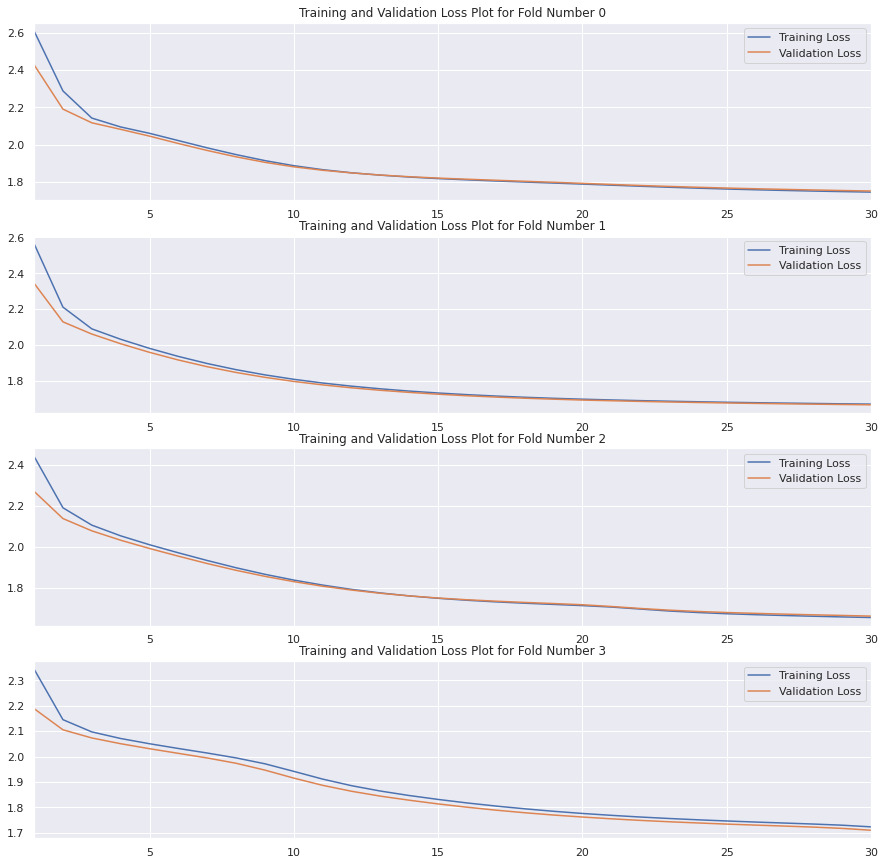

In [ ]:
fig, ax = plt.subplots(num_folds)
fig.set_size_inches(15, 15)
for fold in range(num_folds):
  ax[fold].plot(np.linspace(1, epochs, epochs).astype(int), train_dict[fold], label = "Training Loss")
  ax[fold].plot(np.linspace(1, epochs, epochs).astype(int), val_dict[fold], label = "Validation Loss")
  ax[fold].title.set_text('Training and Validation Loss Plot for Fold Number ' + str(fold))
  ax[fold].margins(x=0)
  ax[fold].legend()

  
  # plt.plot(np.linspace(1, epochs, epochs).astype(int), train_dict[fold])
  # plt.plot(np.linspace(1, epochs, epochs).astype(int), val_dict[fold])

  # plt.plot(epochs, train_dict[fold])
  # plt.plot(epochs,val_dict[fold])

  # print(train_dict[fold])
  # print(val_dict[fold])

In [ ]:
epochs = 30
net = Net(D,numGenres)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00005, momentum=0.9)
print()
print()
xtrain = trainx.numpy()
ytrain = trainy_le.reshape((N,))

trainloader = torch.utils.data.DataLoader(MillionSongTrainDataset(xtrain,ytrain), batch_size=batch_size, shuffle=True)

train_losses = []
for epoch in range(epochs):

  net.train()
  running_loss = 0.0
  valid_running_loss = 0.0
  for i,data in tqdm(enumerate(trainloader,0), desc = training_str_templ.format(numFold=0,numEpoch=epoch)):
    local_batch, local_labels = data
    optimizer.zero_grad()
    outputs = net(local_batch.float())
    loss = criterion(outputs, local_labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()


  print(f'[Epoch: {epoch}, Num Mini-batches: {len(trainloader):5d}] Training loss: {running_loss / len(trainloader):.3f}')
  train_losses.append(running_loss / len(trainloader))

Training for Fold Number 0; Epoch Number 0: 5262it [00:04, 1112.09it/s]


[Epoch: 0, Num Mini-batches:  5262] Training loss: 2.553


Training for Fold Number 0; Epoch Number 1: 5262it [00:04, 1112.41it/s]


[Epoch: 1, Num Mini-batches:  5262] Training loss: 2.155


Training for Fold Number 0; Epoch Number 2: 5262it [00:04, 1114.99it/s]


[Epoch: 2, Num Mini-batches:  5262] Training loss: 2.057


Training for Fold Number 0; Epoch Number 3: 5262it [00:04, 1095.98it/s]


[Epoch: 3, Num Mini-batches:  5262] Training loss: 2.000


Training for Fold Number 0; Epoch Number 4: 5262it [00:04, 1111.71it/s]


[Epoch: 4, Num Mini-batches:  5262] Training loss: 1.956


Training for Fold Number 0; Epoch Number 5: 5262it [00:04, 1109.21it/s]


[Epoch: 5, Num Mini-batches:  5262] Training loss: 1.923


Training for Fold Number 0; Epoch Number 6: 5262it [00:04, 1105.20it/s]


[Epoch: 6, Num Mini-batches:  5262] Training loss: 1.899


Training for Fold Number 0; Epoch Number 7: 5262it [00:04, 1108.64it/s]


[Epoch: 7, Num Mini-batches:  5262] Training loss: 1.879


Training for Fold Number 0; Epoch Number 8: 5262it [00:04, 1108.97it/s]


[Epoch: 8, Num Mini-batches:  5262] Training loss: 1.862


Training for Fold Number 0; Epoch Number 9: 5262it [00:04, 1113.39it/s]


[Epoch: 9, Num Mini-batches:  5262] Training loss: 1.846


Training for Fold Number 0; Epoch Number 10: 5262it [00:04, 1109.93it/s]


[Epoch: 10, Num Mini-batches:  5262] Training loss: 1.834


Training for Fold Number 0; Epoch Number 11: 5262it [00:04, 1119.40it/s]


[Epoch: 11, Num Mini-batches:  5262] Training loss: 1.823


Training for Fold Number 0; Epoch Number 12: 5262it [00:04, 1120.05it/s]


[Epoch: 12, Num Mini-batches:  5262] Training loss: 1.815


Training for Fold Number 0; Epoch Number 13: 5262it [00:04, 1112.95it/s]


[Epoch: 13, Num Mini-batches:  5262] Training loss: 1.808


Training for Fold Number 0; Epoch Number 14: 5262it [00:04, 1108.07it/s]


[Epoch: 14, Num Mini-batches:  5262] Training loss: 1.803


Training for Fold Number 0; Epoch Number 15: 5262it [00:04, 1092.83it/s]


[Epoch: 15, Num Mini-batches:  5262] Training loss: 1.798


Training for Fold Number 0; Epoch Number 16: 5262it [00:04, 1106.36it/s]


[Epoch: 16, Num Mini-batches:  5262] Training loss: 1.794


Training for Fold Number 0; Epoch Number 17: 5262it [00:04, 1117.94it/s]


[Epoch: 17, Num Mini-batches:  5262] Training loss: 1.790


Training for Fold Number 0; Epoch Number 18: 5262it [00:04, 1103.75it/s]


[Epoch: 18, Num Mini-batches:  5262] Training loss: 1.787


Training for Fold Number 0; Epoch Number 19: 5262it [00:04, 1119.54it/s]


[Epoch: 19, Num Mini-batches:  5262] Training loss: 1.784


Training for Fold Number 0; Epoch Number 20: 5262it [00:04, 1099.60it/s]


[Epoch: 20, Num Mini-batches:  5262] Training loss: 1.782


Training for Fold Number 0; Epoch Number 21: 5262it [00:04, 1108.53it/s]


[Epoch: 21, Num Mini-batches:  5262] Training loss: 1.779


Training for Fold Number 0; Epoch Number 22: 5262it [00:04, 1103.86it/s]


[Epoch: 22, Num Mini-batches:  5262] Training loss: 1.777


Training for Fold Number 0; Epoch Number 23: 5262it [00:04, 1103.25it/s]


[Epoch: 23, Num Mini-batches:  5262] Training loss: 1.775


Training for Fold Number 0; Epoch Number 24: 5262it [00:04, 1101.54it/s]


[Epoch: 24, Num Mini-batches:  5262] Training loss: 1.774


Training for Fold Number 0; Epoch Number 25: 5262it [00:04, 1111.91it/s]


[Epoch: 25, Num Mini-batches:  5262] Training loss: 1.772


Training for Fold Number 0; Epoch Number 26: 5262it [00:04, 1086.74it/s]


[Epoch: 26, Num Mini-batches:  5262] Training loss: 1.771


Training for Fold Number 0; Epoch Number 27: 5262it [00:04, 1112.12it/s]


[Epoch: 27, Num Mini-batches:  5262] Training loss: 1.769


Training for Fold Number 0; Epoch Number 28: 5262it [00:04, 1084.92it/s]


[Epoch: 28, Num Mini-batches:  5262] Training loss: 1.768


Training for Fold Number 0; Epoch Number 29: 5262it [00:04, 1094.04it/s]

[Epoch: 29, Num Mini-batches:  5262] Training loss: 1.767


Text(0.5, 1.0, 'Training Loss Over Epochs')

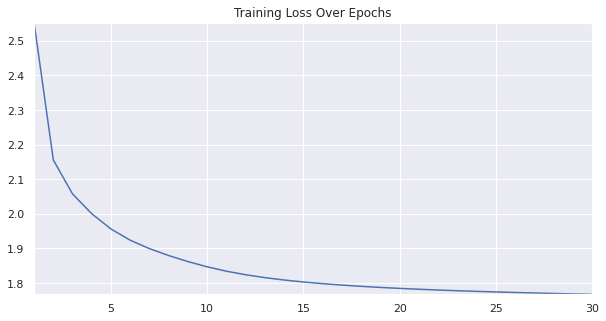

In [ ]:
plt.rcParams['figure.figsize'] = 10, 5
plt.margins(0)
plt.plot(np.linspace(1, epochs, epochs).astype(int), train_losses, label = "Training Loss")
plt.title("Training Loss Over Epochs")

In [ ]:
xtest = testx.numpy()
ytest = testy_le.reshape((testy_le.shape[0],))

testloader = torch.utils.data.DataLoader(MillionSongTrainDataset(xtest,ytest), batch_size=batch_size, shuffle=True)


net.eval()
total_correct = 0
total_entries = 0
for test_data, test_labels in testloader:
  output = net(test_data.float())
  count_correct = np.sum(np.argmax(output.detach().numpy(),axis = 1)== test_labels.numpy())
  total_correct += count_correct
  total_entries +=test_labels.shape[0]

print("Total test accuracy = {acc}".format(acc = total_correct/total_entries))

Total test accuracy = 0.4919824207150493
